# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

## **Questions completed: 1 & 5**

### Import Packages

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

### **1.1: Load cars_hw.csv. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.**

In [114]:
# import data, examine head & shape
cars = pd.read_csv("./data/cars_hw.csv")
print(cars.head())
print("Shape: ", cars.shape)

   Unnamed: 0        Make  Make_Year   Color  Body_Type  Mileage_Run  \
0           1  Volkswagen       2017  silver      sedan        44611   
1           2     Hyundai       2016     red  crossover        20305   
2           3       Honda       2019   white        suv        29540   
3           4     Renault       2017  bronze  hatchback        35680   
4           5     Hyundai       2017  orange  hatchback        25126   

  No_of_Owners  Seating_Capacity Fuel_Type Transmission Transmission_Type  \
0          1st                 5    diesel      7-Speed         Automatic   
1          1st                 5    petrol      5-Speed            Manual   
2          2nd                 5    petrol      5-Speed            Manual   
3          1st                 5    petrol      5-Speed            Manual   
4          1st                 5    petrol      5-Speed            Manual   

    Price  
0  657000  
1  682000  
2  793000  
3  414000  
4  515000  
Shape:  (976, 12)


#### Clean Data

In [115]:
# Misc. Cleaning
cars['Make'].value_counts() # string
cars['Color'].value_counts() # string
cars['Body_Type'].value_counts() # string
cars['Fuel_Type'].value_counts() # string
cars['Transmission'].value_counts() # string
cars['Transmission_Type'].value_counts() # string

cars['Make_Year'] = cars['Make_Year'].astype('category')
cars['No_of_Owners'] = cars['No_of_Owners'].str.replace(r'\D', '', regex=True).astype(int)
cars = cars.drop(cars.columns[0], axis = 1)

In [116]:
y = cars['Price']
X = cars.drop('Price', axis=1)
# print(X['No_of_Owners'].plot.box())
# print(X['Seating_Capacity'].plot.box())
# print(X['Mileage_Run'].plot.box()) # no outliers

In [117]:
def windsorize(x):
    # Convert to a NumPy array
    x = np.array(x)
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

In [118]:
X['No_of_Owners'] = X['No_of_Owners'].apply(windsorize)
X['Seating_Capacity'] = X['Seating_Capacity'].apply(windsorize)
X.head()

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type
0,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic
1,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual
2,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual
3,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual
4,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual


In [119]:
# X['No_of_Owners'].hist()
# X['nowners_log'] = np.log(cars['No_of_Owners'])
# X['nowners_log'].hist(bins=20,grid=False)

### **1.2 Summarize the Price variable and create a kernel density plot. Use .groupby() and .describe() to summarize prices by brand (Make). Make a grouped kernel density plot by Make. Which car brands are the most expensive? What do prices look like in general?**

In [120]:
# Summarize Price Variable
price_summary = cars.groupby('Make')['Price'].describe()
print("Price by brand: ", price_summary)

Price by brand:                 count          mean           std        min        25%  \
Make                                                                     
Chevrolet        6.0  4.535000e+05  2.466064e+05   267000.0   288500.0   
Datsun           3.0  2.896667e+05  1.050397e+04   279000.0   284500.0   
Ford            52.0  7.211731e+05  1.409277e+05   290000.0   635000.0   
Honda           73.0  7.989726e+05  2.665091e+05   316000.0   581000.0   
Hyundai        305.0  6.918918e+05  2.791597e+05   248000.0   485000.0   
Jeep             4.0  1.499500e+06  1.525134e+05  1290000.0  1447500.0   
Kia              8.0  1.614750e+06  1.190567e+05  1369000.0  1579000.0   
MG Motors       35.0  1.869457e+06  1.216611e+05  1589000.0  1786500.0   
Mahindra        18.0  1.100167e+06  1.755493e+05   796000.0  1037000.0   
Maruti Suzuki  293.0  5.887850e+05  2.160199e+05   237000.0   411000.0   
Nissan           4.0  8.842500e+05  2.895599e+05   475000.0   782500.0   
Renault         68.0 

In [137]:
# Kernel Density Plot for Price
# plt.figure(figsize=(10, 6))
# sns.kdeplot(cars['Price'], fill=True)
# plt.title('Kernel Density Plot of Prices')
# plt.xlabel('Price')
# plt.show()

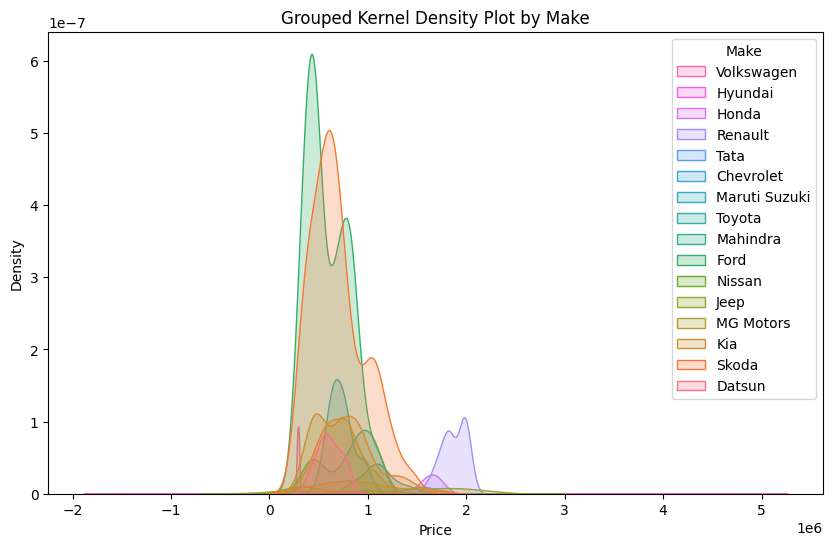

In [140]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=cars, x='Price', hue='Make', fill=True, label='Make')
car_makes = cars['Make'].unique()
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, car_makes, title='Make')
plt.title('Grouped Kernel Density Plot by Make')
plt.xlabel('Price')
plt.show()

### Which car brands are the most expensive? What do prices look like in general?

According to the kernel density plot and summary, Renault, Honda, and some of Skoda cars are the most expensive brands. In general though, most car brands are in a similar price range. Renault is the main most expensive one, while the rest tends to stay in the same 0-1 range.

### **1.3 Split the data into an 80% training set and a 20% testing set.**



In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

### **1.4 Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the  R2  and RMSE on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the  R2  and RMSE on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the  R2  and RMSE on the test set? Does the joint model perform better or worse, and by home much?**

In [124]:
numerical_vars = ['Seating_Capacity', 'Make_Year', 'Mileage_Run']
categorical_vars = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']

In [125]:
# NUMERICAL MODEL:
X_train_num = X_train[numerical_vars]
X_test_num = X_test[numerical_vars]

# X_train_num.head()
# X_test_num.head()

model_num = LinearRegression()
model_num.fit(X_train_num, y_train)

y_pred_num = model_num.predict(X_test_num)

print("Intercept Value: ", model_num.intercept_)
print("Regression Coefficients: ", model_num.coef_)
print("Numeric R2: ", model_num.score(X_test_num, y_test))
print("Numeric RMSE: ", np.sqrt(np.mean((y_pred_num - y_test) ** 2)))

# Intercept Value:  -171276542.0670256
# Regression Coefficients:  [6.61880152e+04 8.50523020e+04 3.10892155e+00]
# R2 Numeric:  0.25720210117170594
# RMSE Numeric:  320530.0950887167

Intercept Value:  -171276542.0670256
Regression Coefficients:  [6.61880152e+04 8.50523020e+04 3.10892155e+00]
Numeric R2:  0.25720210117170594
Numeric RMSE:  320530.0950887167


In [126]:
# CATEGORICAL MODEL:
X_train_cat = X_train[categorical_vars]
X_test_cat = X_test[categorical_vars]

encoder = OneHotEncoder(sparse=False, drop='first')
Xtrain_cod = encoder.fit_transform(X_train_cat)
Xtest_cod = encoder.transform(X_test_cat)

# Train the model
model_cat = LinearRegression()
model_cat.fit(Xtrain_cod, y_train)

r2_cat = model_cat.score(Xtest_cod, y_test)
y_pred_cat = model_cat.predict(Xtest_cod)
rmse_cat = np.sqrt(np.mean((y_pred_cat - y_test) ** 2))
print("Categorical R2:", r2_cat)
print("Categorical RMSE:", rmse_cat)

# R2 Categorical: 0.5873203968563383
# RMSE Categorical: 238913.10974940148

Categorical R2: 0.5873203968563383
Categorical RMSE: 238913.10974940148


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [127]:
X_combined_train = np.concatenate((X_train_num, Xtrain_cod), axis=1)
X_combined_test = np.concatenate((X_test_num, Xtest_cod), axis=1)

model_combined = LinearRegression()
model_combined.fit(X_combined_train, y_train)
r2_combined = model_combined.score(X_combined_test, y_test)
y_pred_combined = model_combined.predict(X_combined_test)
rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
print("Combined R2:", r2_combined)
print("Combined RMSE:", rmse_combined)

# R2 Combined: 0.735416611183433
# RMSE Combined: 191299.91031480476

Combined R2: 0.735416611183433
Combined RMSE: 191299.91031480476


### Values and Analysis (Written Portion):
Numerical Values:
* R2:  0.25720210117170594
* RMSE:  320530.0950887167

Categorical Values:
* R2: 0.5873203968563383
* RMSE: 238913.10974940148

Combined Model Values:
* R2: 0.735416611183433
* RMSE: 191299.91031480476

Between the numeric and categorical models, the categorical model did better in terms of R2 values (a higher value indicates that it has a better fit) and RMSE values (a lower value indicates that there is less error between predicted and actual values). However, the combined model does the best significantly in both terms of R2 and RMSE values.

### **1.5 Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the  R2  and RMSE change? At what point does  R2  go negative on the test set? For your best model with expanded features, what is the  R2  and RMSE? How does it compare to your best model from part 3?**

In [128]:
def expander(deg, X_train_num=X_train_num, X_test_num=X_test_num, Xtrain_cod=Xtrain_cod, Xtest_cod=Xtest_cod):
  expander = PolynomialFeatures(degree=deg, include_bias=False)
  Z_train = expander.fit_transform(X_train_num)
  names = expander.get_feature_names_out()
  X_train_lm = pd.DataFrame(data=Z_train, columns = names)

  Z_test = expander.fit_transform(X_test_num)
  names = expander.get_feature_names_out()
  X_test_lm = pd.DataFrame(data=Z_test, columns = names)

  X_combined_train = np.concatenate((X_train_lm, Xtrain_cod), axis=1)
  X_combined_test = np.concatenate((X_test_lm, Xtest_cod), axis=1)

  # run new model
  model_combined = LinearRegression()
  model_combined.fit(X_combined_train, y_train)
  r2_combined = model_combined.score(X_combined_test, y_test)
  y_pred_combined = model_combined.predict(X_combined_test)
  rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
  print("DEGREE = ", deg)
  print("R2:", r2_combined)
  print("RMSE:", rmse_combined, "\n")

for i in range(1,20):
  expander(i)


DEGREE =  1
R2: 0.735416611183433
RMSE: 191299.91031480476 

DEGREE =  2
R2: 0.7332726224851123
RMSE: 192073.4231931802 

DEGREE =  3
R2: 0.7044153181257765
RMSE: 202196.87584404473 

DEGREE =  4
R2: 0.23496197843941757
RMSE: 325293.2030955246 

DEGREE =  5
R2: 0.24784171769965346
RMSE: 322543.3558031311 

DEGREE =  6
R2: 0.2361625072107828
RMSE: 325037.87122623285 

DEGREE =  7
R2: 0.24022783194340502
RMSE: 324171.75285394484 

DEGREE =  8
R2: -0.007886956429413061
RMSE: 373369.9756915086 

DEGREE =  9
R2: 0.20410364622030153
RMSE: 331788.81140292395 

DEGREE =  10
R2: -1.3505941792651415
RMSE: 570193.55919291 

DEGREE =  11
R2: -0.48013889434625145
RMSE: 452464.7126249616 

DEGREE =  12
R2: -0.051788987036705425
RMSE: 381415.0175763696 

DEGREE =  13
R2: -0.5194295374532425
RMSE: 458430.7716603186 

DEGREE =  14
R2: -1.7761267657788986
RMSE: 619659.5192857592 

DEGREE =  15
R2: -2.0375839147126813
RMSE: 648182.9772304288 

DEGREE =  16
R2: -0.8138959723613208
RMSE: 500886.89292525855

### Analysis (Written Portion):

As the degree of expansion increases, the R2 decreases and the RSME increases. This indicates that the model is progressively getting less and less accurate and precise.

The R2 values begin to go negative at degree >= 8.

The best model with expanded features is when degree = 1. The R2 is 0.735416611183433, and the RMSE is 191299.91031480476. Compared to the combined model, they both have the same R2 and RMSE values. The second best model with expanded features is when degree = 2, and is worse than the combined model from the previous question. Since the models progressively get worse from here on, the combined model from part 3 is better.

### **1.6 For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.**

In [129]:
# ORIGINAL MODEL:
X_combined_train = np.concatenate((X_train_num, Xtrain_cod), axis=1)
X_combined_test = np.concatenate((X_test_num, Xtest_cod), axis=1)

model_combined = LinearRegression()
model_combined.fit(X_combined_train, y_train)
r2_combined = model_combined.score(X_combined_test, y_test)
y_pred_combined = model_combined.predict(X_combined_test)
rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
print("R2:", r2_combined)
print("RMSE:", rmse_combined)

R2: 0.735416611183433
RMSE: 191299.91031480476


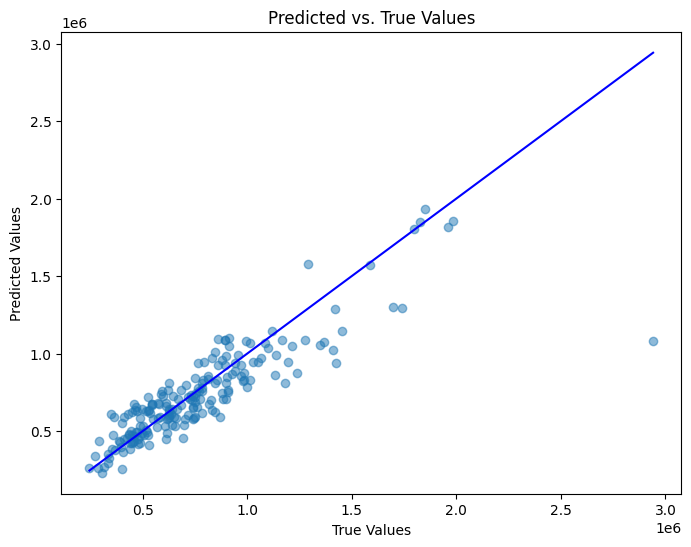

In [130]:
# PLOT
# plot data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_combined, alpha=0.5)
plt.title("Predicted vs. True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue')
plt.show()

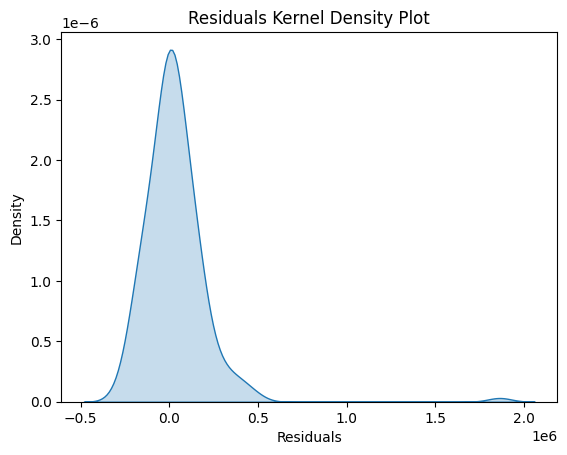

In [131]:
# RES/ERRORS:
res = y_test - y_pred_combined

sns.kdeplot(res, fill=True)
plt.title("Residuals Kernel Density Plot")
plt.xlabel("Residuals")

# Show the plot
plt.show()

### Analysis (Written Portion):
**Diagonal Line:** The predicted and true values roughly line up the diagonal, however there is one significant outlier.

**Residuals and Errors:** The residual does look bell-shaped around zero. There is a slight curve at around 2, but it is significantly lower compared to the main bell-shaped curve.

**Strengths and Weaknesses:** The strength of this model is that with the majority of the values, model is that it's fairly accurate. Most values remain in a good accuracy and precision range. The weakness is that when it comes to some of the larger true values, the predicted values become less and less accurate.

### **1.7 Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the  R2  and RMSE on the test set of a variety of depths. What depth tree gives the best results?**

In [132]:
best_depth = None
best_r2 = -float('inf')
best_rmse = float('inf')

for depth in range(1, 15):  # Example range from 1 to 14
    tree_regressor = tree.DecisionTreeRegressor(max_depth=depth)
    cart = tree_regressor.fit(X_combined_train, y_train)

    y_pred_cart = cart.predict(X_combined_test)
    res_cart = y_test - y_pred_cart

    r2_tree = tree_regressor.score(X_combined_test, y_test)
    rmse_tree = np.sqrt(np.mean((y_pred_cart - y_test) ** 2))

    print(f"Depth: {depth}, R2: {r2_tree}, RMSE: {rmse_tree}")

    if r2_tree > best_r2:
        best_r2 = r2_tree
        best_rmse = rmse_tree
        best_depth = depth

print(f"Best Depth: {best_depth}, Best R2: {best_r2}, Best RMSE: {best_rmse}")
# Best Depth: 10, Best R2: 0.7048409240376378, Best RMSE: 202051.25397842616

Depth: 1, R2: 0.23303643787927641, RMSE: 325702.3145423058
Depth: 2, R2: 0.4640432606256073, RMSE: 272269.09466180863
Depth: 3, R2: 0.636424196804323, RMSE: 224249.23243372503
Depth: 4, R2: 0.6590652039937961, RMSE: 217154.65476804218
Depth: 5, R2: 0.6636791689863217, RMSE: 215680.24233313274
Depth: 6, R2: 0.6939589957784247, RMSE: 205742.1568153241
Depth: 7, R2: 0.6874744113930844, RMSE: 207910.42682609905
Depth: 8, R2: 0.7006396387200899, RMSE: 203484.1686836039
Depth: 9, R2: 0.714688751685955, RMSE: 198651.99278753827
Depth: 10, R2: 0.7061186140320483, RMSE: 201613.45810215003
Depth: 11, R2: 0.7004905497495333, RMSE: 203534.8324870328
Depth: 12, R2: 0.694426237708015, RMSE: 205585.0404800743
Depth: 13, R2: 0.6873801019644454, RMSE: 207941.79455285837
Depth: 14, R2: 0.6896150335546174, RMSE: 207197.16941204044
Best Depth: 9, Best R2: 0.714688751685955, Best RMSE: 198651.99278753827


### Analysis (Written Portion):
In a range of 1 to 14, the best results was given when the tree depth is equal to 9 (R2 = 0.712135346599019, and RMSE = 199538.9349827774).

### **1.8 For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?**

In [133]:
# Best Tree:
tree_regressor = tree.DecisionTreeRegressor(max_depth=10)
cart = tree_regressor.fit(X_combined_train, y_train)

y_pred_cart = cart.predict(X_combined_test)
res_cart = y_test - y_pred_cart

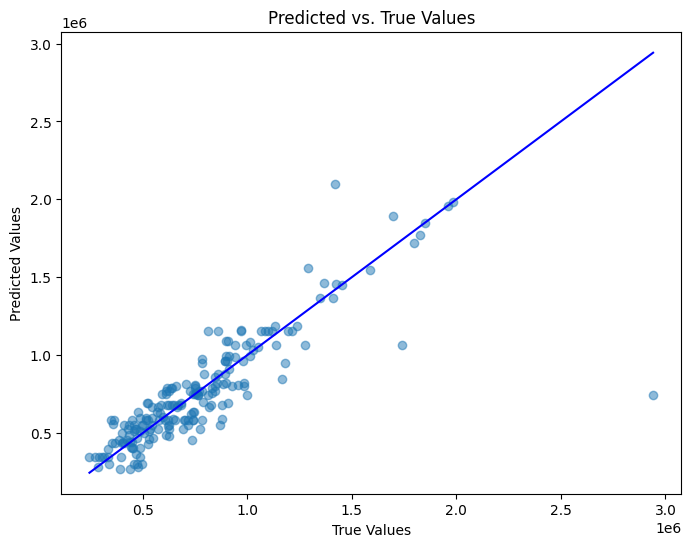

In [134]:
# PLOT
# plot data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_cart, alpha=0.5)
plt.title("Predicted vs. True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

# line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue')

# Show the plot
plt.show()

# does roughly follow line

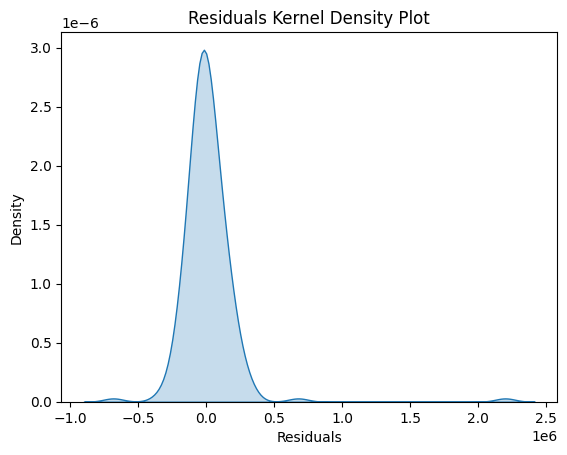

In [135]:
# RES/ERRORS:
res = y_test - y_pred_cart

sns.kdeplot(res, fill=True)
plt.title("Residuals Kernel Density Plot")
plt.xlabel("Residuals")

# Show the plot
plt.show()

# few res. at around 2.3, and has some other bumps, but for the most part, graph is centered at 0 and has a bell curve

### Analysis (Written Portion):
Similarly to the linear model, the tree model did roughly follow the diagonal for in this graph, with one main extreme outlier. The residual looks mostly bell-shaped around zero, however it can be seen that there are two other very small curves at around 0.7, and 2.2.

### **1.9 Which model --- linear model or classification and regression tree --- has better performance on the test set?**

Based on the R2 and RMSE values, it can be concluded that on this test set, the linear model outperformed the regression tree.

The linear model had a higher R2 value (0.735416611183433 (linear) - 0.712135346599019 (reg. tree) = 0.02328126458), and had a lower RMSE (191299.91031480476 (linear) - 199538.9349827774 (reg. tree) = -8239.02466797).

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?

### **Questions 5.1-5.3:**

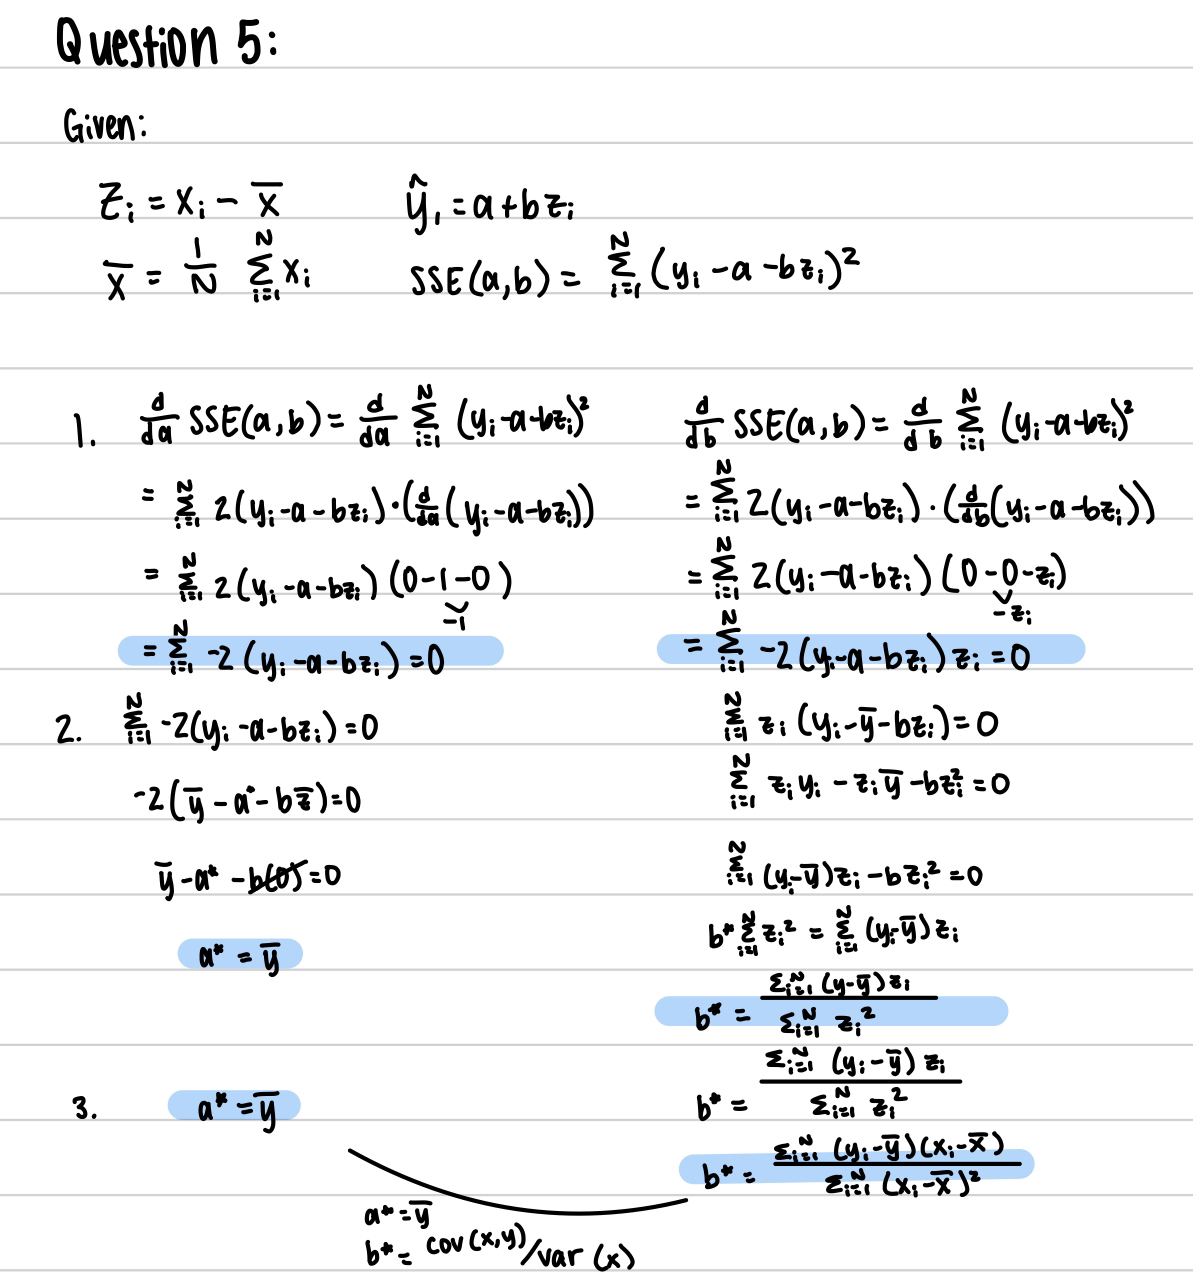

In [136]:
from IPython.display import Image

Image(filename='./ds3001_q5.png')

### **Question 5.4: When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?**
$b^*$ will be larger when there is a stronger relationship (linearly) between $x$ and $y$ because with a strong $x$ and $y$ relationship, a higher covariance will be produced since they will have a higher dependency. Since covariance is the numerator, a higher covariance will indicate a larger $b*$ value.

Contrasingly, when the relationship between $x$ and $y$ is weaker/does not exist, the covariance will be smaller, and lead to a smaller $b^*$ value. However, this may also depend on the variability of $x$ on its own, which may affect the value of $b^*$ no matter what the covariance is (higher $var(x)$ --> lower $b^*$ value, and vice versa).

$a^*$ represents the y-intercept in the linear regression model. It essentially gives the ouput of the value of dependent variable $y$ when all other predictor variables are equal to zero.

### **Question 5.5: Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called *attenuation*.)**

Having a measurement error in $x$ that artificially inflates its variance may lead to a lower $b^*$ value (because the variance will be higher when there is more measurement error). In general, it also has a tendency to weaken the observed relationship between x and y, and makes the relationship seem weaker or less visible than it actually is.

### **Question 5.6: Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?**

When significantly increasing a single value of $y_i$ or $x_i$, the $a^*$ and $b^*$ values can also significantly be affected due to the relationships between these values. OLS aims to reduce the squared differences, but having a single value be significantly increased can cause the $a^*$ and $b^*$ values to accommodate for that outlier (even if it wasn't a necessary value) and could completely affect the results, which is not ideal.

This would mean the model will not perform well for more average observations. Since it's so focused on getting the outlier to also fit in, the model may overfit the data and cause there to be far less accurate results for more average observations, which will then affect future predictions/uses of the dataset.